<a href="https://colab.research.google.com/github/Alejandro-ZZ/Deep-Learning/blob/master/Convolutional-Networks/CIFAR10_tensorflow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Multiple Classification | Tensorflow**

In [1]:
import tensorflow as tf

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization

from tensorflow.keras import regularizers, optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator


import time
import numpy as np
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split

## **CIFAR10 dataset**

This dataset has 50,000 32x32 color training images and 10,000 test images, labeled over 10 categories. See more info at the [CIFAR homepage](https://www.cs.toronto.edu/~kriz/cifar.html).

170498071/170498071 [==============================] - 2s 0us/step


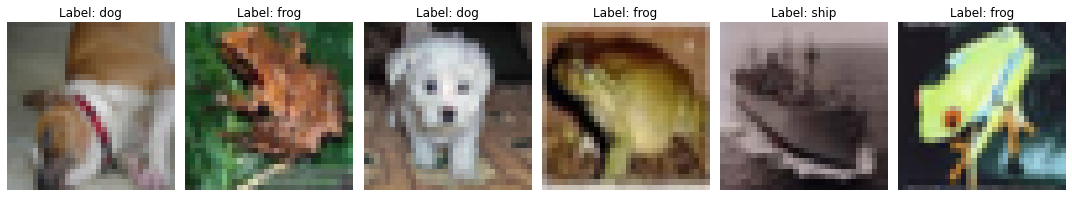

In [2]:
# Download the dataset
(x_data, y_data), (x_test, y_test) = cifar10.load_data()


# Classes
classes = {0: 'airplane', 
           1: 'automobile',
           2: 'bird',
           3: 'cat',
           4: 'deer',
           5: 'dog',
           6: 'frog',
           7: 'horse',
           8: 'ship',
           9:	'truck'}

# Get random observation
cols, rows = 6, 1
index_list = list(np.random.randint(0, len(x_data), cols))

# Display image
figure = plt.figure(figsize=(15, 15))
for i, index in enumerate(index_list):
  figure.add_subplot(rows, cols, i+1)
  plt.imshow(x_data[index])
  plt.title(f'Label: {classes[y_data[index][0]]}')
  plt.axis("off")
plt.tight_layout()
plt.show()

In [3]:
# Normalize values in range [0, 1]
x_data = (x_data / 255).astype('float32')
x_test = (x_test / 255).astype('float32')

# mean = np.mean(x_train)
# std = np.std(x_train)
# x_data = (x_data - mean) / (std+1e-7)
# x_test = (x_test - mean) / (std+1e-7)

# One-Hot Encoding
num_clases = len(np.unique(y_data))
y_data = to_categorical(y_data, num_clases)
y_test = to_categorical(y_test, num_clases)


# Train & Validation set
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, 
                                                  train_size=0.8, 
                                                  random_state=23)

# Data shapes
print("Train data ", x_data.shape)
print("Train labels ", y_data.shape)
print("-"*50)
print("Validation data ", x_val.shape)
print("Validation labels ", y_val.shape)
print("-"*50)
print("Test data ", x_test.shape)
print("Test labels ", y_test.shape)

Train data  (50000, 32, 32, 3)
Train labels  (50000, 10)
--------------------------------------------------
Validation data  (10000, 32, 32, 3)
Validation labels  (10000, 10)
--------------------------------------------------
Test data  (10000, 32, 32, 3)
Test labels  (10000, 10)


### *Data augmentation*

In [4]:
datagen = ImageDataGenerator(rotation_range=15,
                  width_shift_range=0.1,
                  height_shift_range=0.1,
                  horizontal_flip=True,
                  vertical_flip=True)

## **Convolutional model**

In [5]:
def build_model(input_shape):
  
  model = Sequential()

  ## Convolution 1
  model.add(Conv2D(BASE_FILTERS, (3,3), padding='same', 
                  kernel_regularizer=REGULARIZER, input_shape=input_shape))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  ## Convolution 2
  model.add(Conv2D(BASE_FILTERS, (3,3), padding='same', 
                  kernel_regularizer=REGULARIZER))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.2))

  ## Convolution 3
  model.add(Conv2D(2*BASE_FILTERS, (3,3), padding='same', 
                  kernel_regularizer=REGULARIZER))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))

  ## Convolution 4
  model.add(Conv2D(2*BASE_FILTERS, (3,3), padding='same', 
                  kernel_regularizer=REGULARIZER))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.3))

  ## Convolution 5
  model.add(Conv2D(4*BASE_FILTERS, (3,3), padding='same', 
                  kernel_regularizer=REGULARIZER))
  model.add(Activation('relu'))
  model.add(BatchNormalization())

  ## Convolution 6
  model.add(Conv2D(4*BASE_FILTERS, (3,3), padding='same', 
                  kernel_regularizer=REGULARIZER))
  model.add(Activation('relu'))
  model.add(BatchNormalization())
  model.add(MaxPooling2D(pool_size=(2,2)))
  model.add(Dropout(0.4))

  ## Clasificacion - Flatten
  model.add(Flatten())
  model.add(Dense(num_clases,activation='softmax'))

  # Compiling
  model.compile(loss=LOSS_FUNC, optimizer=OPTIMIZER, metrics=METRICS_LIST)

  return model

### *Callbacks* 

In [6]:
# Model weights are saved at the end of every epoch, 
# if it's the best seen so far.
chekcpoint = ModelCheckpoint('best_weights.hdf5', verbose=0, 
                             save_best_only=True, monitor='val_accuracy')


# Stop the training when there is no improvement in
# the validation accuracy for five consecutive epochs.
early = EarlyStopping(monitor='val_accuracy', patience=10)

# Reduce learning rate when a metric has stopped improving.
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9,
                              patience=7, min_lr=0.0001)

## **Hyperparameters**

In [10]:
# Number of output filters in the convolution layers
BASE_FILTERS = 32

# L2 regularization with a factor of 1e-4
REGULARIZER = regularizers.l2(1e-4)

# Number of iterations when training
EPOCHS = 120

BATCH_SIZE = 128

# Optimizer params
LOSS_FUNC = 'categorical_crossentropy'
METRICS_LIST = ['accuracy']
OPTIMIZER = 'adam'

# ------------------------------------------------------

model = build_model(input_shape=x_train.shape[1:])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_6 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_6 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 activation_7 (Activation)   (None, 32, 32, 32)        0         
                                                                 
 batch_normalization_7 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                      

## **Training**

In [11]:
device = tf.test.gpu_device_name()
device_name = device if device else '/cpu:0'
print(f'[INFO] Device in use: {device_name}\n')

with tf.device(device_name):
  start_process_time = time.time()
  # ------------------------------------------------------------------------------
  results = model.fit(datagen.flow(x_train, y_train, batch_size=BATCH_SIZE),
                      verbose=1,
                      epochs=EPOCHS,
                      callbacks=[chekcpoint, early, reduce_lr],
                      validation_data=(x_val, y_val), 
                      steps_per_epoch=x_train.shape[0] // BATCH_SIZE)
  # ------------------------------------------------------------------------------
  process_time = time.time() - start_process_time
  minutes = process_time / 60
  seconds = (minutes - int(minutes)) * 60

  epochs_trained = early.stopped_epoch + 1
  print(f'\n[INFO] Total epochs trained: {epochs_trained}')
  print(f'[INFO] Training execution time: {int(minutes)}m {int(seconds)}s\n')

[INFO] Device in use: /device:GPU:0

Epoch 1/120
312/312 [==============================] - 27s 81ms/step - loss: 2.2742 - accuracy: 0.3200 - val_loss: 3.4932 - val_accuracy: 0.1659 - lr: 0.0010
Epoch 2/120
312/312 [==============================] - 23s 75ms/step - loss: 1.7939 - accuracy: 0.4246 - val_loss: 3.2356 - val_accuracy: 0.2507 - lr: 0.0010
Epoch 3/120
312/312 [==============================] - 23s 74ms/step - loss: 1.6054 - accuracy: 0.4872 - val_loss: 1.7472 - val_accuracy: 0.4951 - lr: 0.0010
Epoch 4/120
312/312 [==============================] - 23s 74ms/step - loss: 1.4491 - accuracy: 0.5321 - val_loss: 1.4841 - val_accuracy: 0.5173 - lr: 0.0010
Epoch 5/120
312/312 [==============================] - 23s 74ms/step - loss: 1.3615 - accuracy: 0.5638 - val_loss: 1.2369 - val_accuracy: 0.5867 - lr: 0.0010
Epoch 6/120
312/312 [==============================] - 22s 71ms/step - loss: 1.2773 - accuracy: 0.5837 - val_loss: 1.3414 - val_accuracy: 0.5992 - lr: 0.0010
Epoch 7/120
312

### *Results*

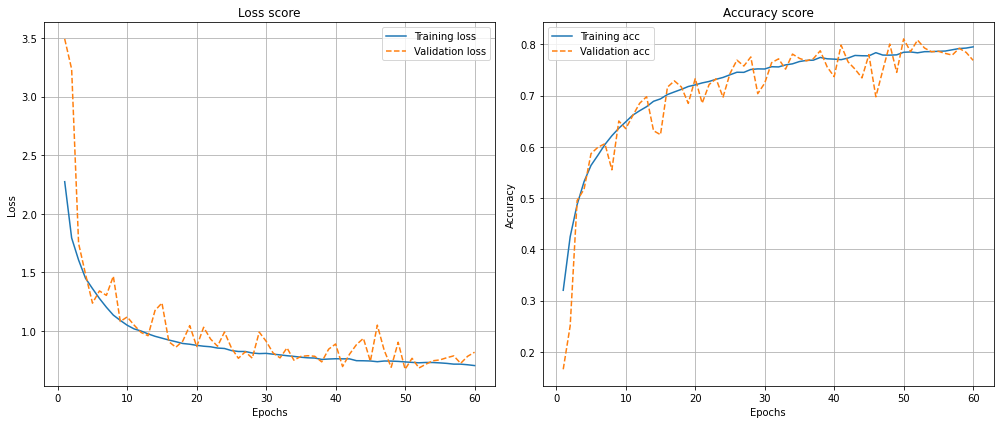

In [18]:
# Get results
results_dict = results.history

# Display training and validation curves
figure = plt.figure(figsize=(14, 6))

figure.add_subplot(1, 2, 1)
plt.plot(range(1, epochs_trained+1), results_dict['loss'], label='Training loss')
plt.plot(range(1, epochs_trained+1), results_dict['val_loss'], '--', label='Validation loss')
plt.title('Loss score')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid()

figure.add_subplot(1, 2, 2)
plt.plot(range(1, epochs_trained+1), results_dict['accuracy'], label='Training acc')
plt.plot(range(1, epochs_trained+1), results_dict['val_accuracy'], '--', label='Validation acc')
plt.title('Accuracy score')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

## **Testing**

In [23]:
# New model with best weights
best_model = model
best_model.load_weights('./best_weights.hdf5')
loss, accuracy = best_model.evaluate(x_test,y_test)
print(f'[INFO] Loss score: {round(loss, 4)}')
print(f'[INFO] Accuracy score: {round(accuracy, 4)}')

313/313 [==============================] - 1s 4ms/step - loss: 0.6907 - accuracy: 0.8066
[INFO] Loss score: 0.6907
[INFO] Accuracy score: 0.8066


### *Predictions*

In [53]:
# Get predictions of test observations
print('[INFO] Getting predictions...')
predictions = best_model.predict(x_test)

# Probability for test observation 0
# position of each probability corresponts 
# to the respective target number
random_index = np.random.randint(0, x_test.shape[0])
print('\nRandom prediction:')
for i, pred in enumerate(predictions[random_index]):
  print(f'\t* {classes[i]}: {pred}')

# Sum of all prediction of observation 0 
# must be 1 (equivalent to 100% of probability)
print('-'*45, '\nSum of predictions:', np.sum(predictions[random_index]))

# Get the position with higher probability (final prediction of model)
print('\nFinal prediction:', classes[np.argmax(predictions[random_index])])

# True value
print('Actual value:', classes[np.argmax(y_test[random_index])])

[INFO] Getting predictions...
313/313 [==============================] - 1s 3ms/step

Random prediction:
	* airplane: 0.0002487023884896189
	* automobile: 0.8668403029441833
	* bird: 3.965747339407244e-07
	* cat: 1.0554500704529346e-06
	* deer: 1.799365492161087e-07
	* dog: 1.1774412200793449e-07
	* frog: 6.285798463068204e-06
	* horse: 1.0067587936646305e-05
	* ship: 1.9075052478001453e-05
	* truck: 0.1328737586736679
--------------------------------------------- 
Sum of predictions: 0.99999994

Final prediction: automobile
Actual value: automobile


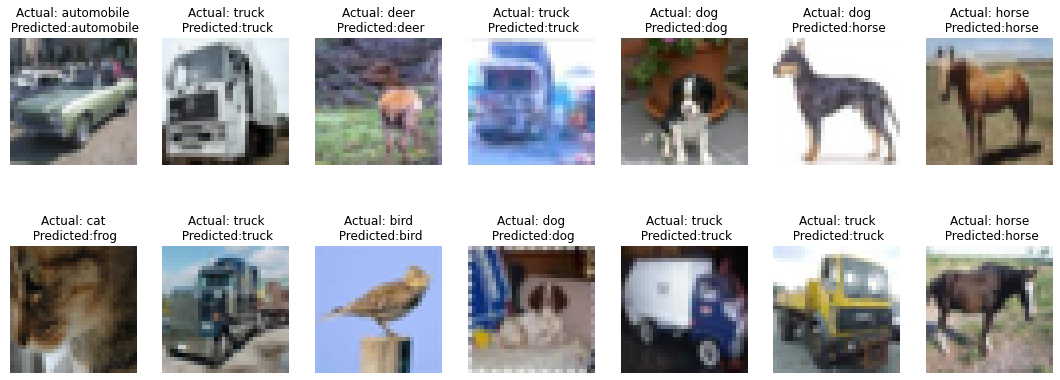

In [52]:
# Grid to plot
rows, cols = 2, 7

# Random test observations
index_list = list(np.random.randint(0, len(x_test), cols*rows))

  
figure = plt.figure(figsize=(15, 15))
for i, index in enumerate(index_list):
  # Get the position with higher probability (final prediction of model)
  predicted = np.argmax(predictions[index])

  figure.add_subplot(rows, cols, i+1)
  plt.imshow(x_test[index], 'gray')
  plt.title(f'Actual: {classes[np.argmax(y_test[index])]}\n Predicted:{classes[predicted]}')
  plt.axis('off')

plt.tight_layout()
plt.subplots_adjust(bottom=0.5)
plt.show()